Submission Proyek Akhir: Image Classification Model Deployment

Kelas Belajar Pengembangan Machine Learning by Dicoding. 
<br>
<br>
<br>
Nama: Andi Abdul Hafez Ramadhan

Email: etchzel@gmail.com

Mount google drive ke colab

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Rubah working directory ke directory dataset (Dataset sudah di download ke Google Drive menggunakan Kaggle API)

Link dataset: https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [1]:
import os

base_dir = '/content/drive/MyDrive/Kaggle/gtsrb'
os.chdir(base_dir)
print('Working directory changed to {}'.format(os.getcwd()))

Working directory changed to /content/drive/MyDrive/Kaggle/gtsrb


In [2]:
os.listdir()

['Meta.csv',
 'Meta',
 'Test.csv',
 'Test',
 'Train.csv',
 'Train',
 'meta',
 'test',
 'train']

Import library pandas dan load info dataset ke dataframe

In [3]:
import pandas as pd

#grab the information regarding the dataset
train_info = pd.read_csv('Train.csv')
test_info = pd.read_csv('Test.csv')

In [5]:
train_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [6]:
test_info.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


Hitung jumlah class yang akan digunakan untuk klasifikasi

In [7]:
#count the number of classes
class_num = train_info.ClassId.unique().shape[0]
print('Number of class: {}'.format(class_num))

Number of class: 43


Kolom yang digunakan untuk klasifikasi hanya kolom Path yang berisi path lokasi ke image files, dan ClassId yang merupakan label.

In [8]:
#grab the labels and data path into a dataframe
df = train_info[['Path', 'ClassId']]
df

,Path,ClassId
0,Train/20/00020_00000_00000.png,20
1,Train/20/00020_00000_00001.png,20
2,Train/20/00020_00000_00002.png,20
3,Train/20/00020_00000_00003.png,20
4,Train/20/00020_00000_00004.png,20
...,...,...
39204,Train/42/00042_00007_00025.png,42
39205,Train/42/00042_00007_00026.png,42
39206,Train/42/00042_00007_00027.png,42
39207,Train/42/00042_00007_00028.png,42


Import semua library yang diperlukan.

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

%matplotlib inline

Split dataframe yang berisi image path dan class label menjadi train dan validation set.

In [10]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=df.ClassId
)

In [11]:
print('Samples: {}'.format(df.shape[0]))
print('Train samples: {}'.format(train_df.shape[0]))
print('Validation samples: {}'.format(val_df.shape[0]))

Samples: 39209
Train samples: 31367
Validation samples: 7842


Jumlah sampel 39209 dibagi menjadi 31367 train samples (80%) dan 7842 validation samples (20%).
<br><br>
Setelah proses splitting, reset index train dan validation dataframe.

In [12]:
#reset the index after splitting
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

In [13]:
train_df.head()

,Path,ClassId
0,Train/12/00012_00031_00018.png,12
1,Train/5/00005_00031_00001.png,5
2,Train/12/00012_00069_00028.png,12
3,Train/13/00013_00052_00022.png,13
4,Train/18/00018_00017_00024.png,18


Simpan data dan label ke dalam bentuk list, untuk di convert menjadi tensorflow Dataset object

In [14]:
#list the data and labels to be used for tensorflow input pipeline
filenames_train = train_df.Path.values.tolist()
filenames_val = val_df.Path.values.tolist()
labels_train = train_df.ClassId.values.tolist()
labels_val = val_df.ClassId.values.tolist()

Definisikan konstanta yang akan digunakan.

In [20]:
IMG_SIZE = (30,30)
BATCH_SIZE = 256
STEPS_PER_EPOCH = train_df.shape[0] // BATCH_SIZE
VAL_STEPS = val_df.shape[0] // BATCH_SIZE
EPOCH = 50

Fungsi create_img_dataset berfungsi untuk membuat tensorflow Dataset object dari list image paths dan label masing masing.

In [25]:
#utility function to create tensorflow dataset for input
def create_img_dataset(files, labels, target_size=(30,30), batch_size=32, shuffle=True, seed=42):

  #function to parse images from the path provided
  def img_parser(file):
    image = tf.io.read_file(file)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [target_size[0],target_size[1]])
    return image

  #configuration for input
  def configure_for_performance(ds):
    if shuffle:
      ds = ds.shuffle(buffer_size=batch_size*8, seed=seed)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

  #convert list of image path into Dataset object then parse the images
  images_ds = tf.data.Dataset.from_tensor_slices(files)
  images_ds = images_ds.map(
      img_parser,
      num_parallel_calls=tf.data.experimental.AUTOTUNE
  )

  '''convert the labels into Dataset object 
    then map it into a one hot encoded label'''
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)
  labels_ds = labels_ds.map(
      lambda x: tf.one_hot(x, class_num)
  )
  ds = tf.data.Dataset.zip((images_ds, labels_ds))
  ds = configure_for_performance(ds)

  return ds

Load image ke Dataset object untuk digunakan sebagai input ke model

In [27]:
train_dataset = create_img_dataset(
    files=filenames_train,
    labels=labels_train,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_dataset = create_img_dataset(
    files=filenames_val,
    labels=labels_val,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Membuat model menggunakan model class Sequential.

Conv2D layer dan Maxpooling layer digunakan disini.

In [51]:
INPUT_SHAPE = IMG_SIZE + (3,)

model = Sequential([
    tf.keras.layers.InputLayer(input_shape=INPUT_SHAPE),
    Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

In [52]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)        

Custom Callback class untuk stop training ketika kedua metric accuracy dan validation accuracy telah mencapai baseline yang ditentukan.

In [54]:
#custom callback to stop training when baseline is reached
class StopOnBaseline(tf.keras.callbacks.Callback):
  def __init__(self, baseline=0.95):
    self.monitor = 'accuracy'
    self.val_monitor = 'val_accuracy'
    self.baseline = baseline
  
  def on_epoch_end(self, epoch, logs={}):
    metrics = []
    for metric in [self.monitor, self.val_monitor]:
      metrics.append(logs.get(metric))

    if None not in metrics:
      if all(metric >= self.baseline for metric in metrics):
        print('Baseline training and validation accuracy achieved on Epoch #{}'.format(epoch+1))
        print('Training accuracy: {}'.format(metrics[0]))
        print('Validation accuracy: {}'.format(metrics[1]))
        self.model.stop_training = True

List callback yang digunakan:



*   EarlyStopping: stop training jika metric tidak terdapat perkembangan dalam 4 epochs.
*   ModelCheckpoint: save model ke format .h5 tiap epoch jika metric ada perkembangan

*   StopOnBaseline custom callback





In [55]:
callback_list = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=0,
        patience=4,
        verbose=1,
        mode='auto',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='../gtsrb-model.h5',
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='auto'
    ),
    StopOnBaseline(
        baseline=0.95
    )
]

In [56]:
history = model.fit(
    train_dataset,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCH,
    validation_data=val_dataset,
    validation_steps=VAL_STEPS,
    callbacks=callback_list,
    verbose=1
)

Epoch 1/50
122/122 [==============================] - 154s 1s/step - loss: 3.6554 - accuracy: 0.1910 - val_loss: 1.6315 - val_accuracy: 0.5569

Epoch 00001: val_accuracy improved from -inf to 0.55690, saving model to ../gtsrb-model.h5
Epoch 2/50
122/122 [==============================] - 153s 1s/step - loss: 1.3352 - accuracy: 0.6237 - val_loss: 0.4114 - val_accuracy: 0.9089

Epoch 00002: val_accuracy improved from 0.55690 to 0.90885, saving model to ../gtsrb-model.h5
Epoch 3/50
122/122 [==============================] - 156s 1s/step - loss: 0.5877 - accuracy: 0.8317 - val_loss: 0.1601 - val_accuracy: 0.9664

Epoch 00003: val_accuracy improved from 0.90885 to 0.96641, saving model to ../gtsrb-model.h5
Epoch 4/50
122/122 [==============================] - 151s 1s/step - loss: 0.3217 - accuracy: 0.9090 - val_loss: 0.0829 - val_accuracy: 0.9841

Epoch 00004: val_accuracy improved from 0.96641 to 0.98411, saving model to ../gtsrb-model.h5
Epoch 5/50
122/122 [==============================]

Hasil training terlihat dimana training accuracy 0.95 dan validation accuracy 0.99 tercapai di epoch ke 6. <br><br>
Save model dari training tersebut.

In [95]:
save_model_path = os.path.join(base_dir, 'Model')
model.save(save_model_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Kaggle/gtsrb/Model/assets


Fungsi metrics_graph adalah utility function untuk membuat plot loss dan akurasi

In [85]:
def metrics_graph(axis, history, metrics):
  val_metrics = 'val_'+metrics
  axis.plot(history.history[metrics])
  axis.plot(history.history[val_metrics])
  axis.set_xlabel('Epochs')
  axis.set_ylabel(metrics.capitalize())
  axis.set_title('Model '+metrics)
  axis.legend([metrics, val_metrics])
  axis.grid(True)

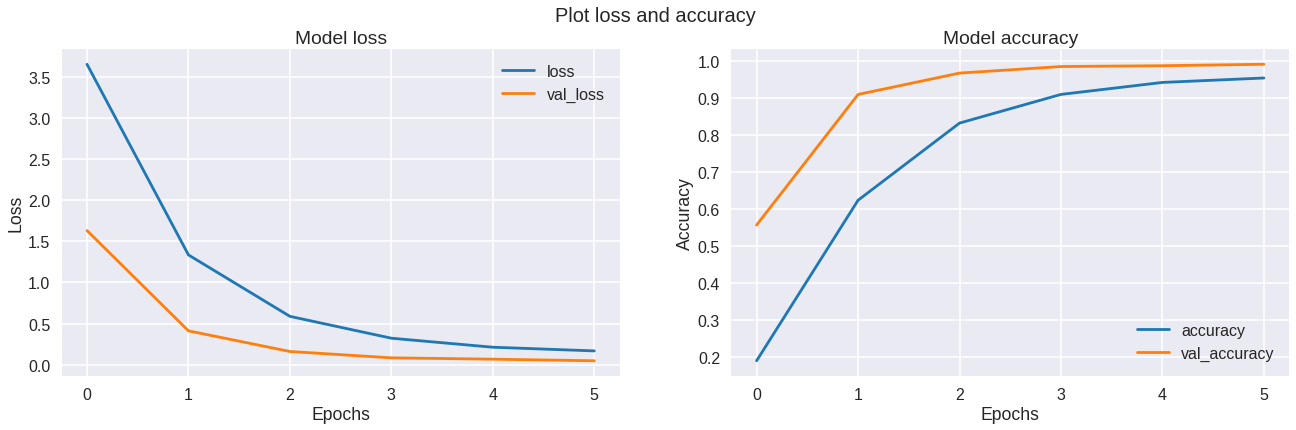

In [93]:
plt.style.use('seaborn-poster')
fig, axs = plt.subplots(1,2,figsize=(22,6), sharex=False)
metrics = ['loss', 'accuracy']

for i, metric in enumerate(metrics):
  metrics_graph(axs[i], history, metric)

fig.suptitle('Plot loss and accuracy', fontsize=20)
plt.show()

Mencoba prediksi menggunakan data test.
Pertama, buat dataframe yang berisikan Path ke test images dan label class nya.

In [98]:
test_df = test_info[['Path', 'ClassId']]
test_df

,Path,ClassId
0,Test/00000.png,16
1,Test/00001.png,1
2,Test/00002.png,38
3,Test/00003.png,33
4,Test/00004.png,11
...,...,...
12625,Test/12625.png,12
12626,Test/12626.png,33
12627,Test/12627.png,6
12628,Test/12628.png,7


Buat dataset dari directory menggunakan fungsi preprocessing dari keras, image_dataset_from_directory

In [108]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [111]:
test_dataset = image_dataset_from_directory(
    'Test',
    labels=None,
    label_mode=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False
)

Found 12630 files belonging to 1 classes.


Mulai prediksi

In [112]:
pred = model.predict(
    test_dataset,
    verbose=1
)

50/50 [==============================] - 1273s 26s/step


Hasil prediksi merupakan one hot encoded dari class label, di convert menjadi single column menggunakan fungsi argmax() dari numpy.
<br><br>
Setelah konversi, bandingkan dengan label class asli yang sudah di berikan di dataframe test

In [175]:
pred_single = pred.argmax(axis=1)
pred_result = (test_df.ClassId.values == pred_single)
result, ct = np.unique(pred_result, return_counts=True)
dict(zip(result,ct))

{False: 483, True: 12147}

Akurasi dari hasil prediksi didapat 0.96

In [180]:
result_accuracy = ct[1] / pred_single.shape[0]
print('Test (Prediction) accuracy: {}'.format(result_accuracy))

Test (Prediction) accuracy: 0.9617577197149644


Terakhir, convert model ke format TF-Lite lalu disimpan.

In [181]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpm75pucvy/assets


In [182]:
with tf.io.gfile.GFile('model.tflite','wb') as f:
  f.write(tflite_model)

Model sudah disimpan menjadi model.tflite

In [183]:
os.listdir()

['Meta.csv',
 'Meta',
 'Test.csv',
 'Test',
 'Train.csv',
 'Train',
 'meta',
 'test',
 'train',
 'Model',
 'model.tflite']